<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Sample Weights
    </h1>
  </div>  
</div>

This notebook demonstrates how to calculate sample weights to address data overlap using the `RiskLabAI` library.

In this tutorial, we will:
1.  Load S&P 500 price data from FRED.
2.  Generate trading signals (events) using the CUSUM filter.
3.  Establish event start/end times using the Triple Barrier Method.
4.  Calculate **Average Uniqueness** from event concurrency.
5.  Compute **Return-Attribution Sample Weights**.
6.  Apply **Time-Decay** to the weights.
7.  Run a Monte Carlo simulation to compare **Sequential vs. Standard Bootstrap** uniqueness.

## 0. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from dotenv import load_dotenv

# Set numpy errors
np.seterr(divide='ignore', invalid='ignore')

# Import functions from RiskLabAI
from RiskLabAI.data.labeling.labeling import (
    daily_volatility_with_log_returns,
    symmetric_cusum_filter,
    vertical_barrier,
    meta_events,
    meta_labeling
)
from RiskLabAI.data.weights.sample_weights import (
    expand_label_for_meta_labeling,
    calculate_average_uniqueness,
    sample_weight_absolute_return_meta_labeling,
    calculate_time_decay
)
import RiskLabAI.utils.publication_plots as pub_plots

# Global Plotting Settings
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Load Data

We will use daily S&P 500 data from FRED. This provides a long, high-quality price series to work with.

In [2]:
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

# To run the code on your computer, register for a free FRED API and uncomment the following line
# FRED_API_KEY = 'YOUR_FRED_API_KEY'

FRED_API_KEY = os.environ.get('FRED_API_KEY')

if not FRED_API_KEY:
    print("Warning: FRED_API_KEY not found. Please set it in a .env file or manually.")
    FRED_API_KEY = 'YOUR_FRED_API_KEY_HERE' # Fails gracefully if no key is found
else:
    print("FRED API Key loaded.")

fred = Fred(api_key=FRED_API_KEY)

# Load S&P 500 data
close = fred.get_series('SP500', start_date="2010-01-01").dropna().to_frame('close')

print(f"Loaded {close.shape[0]} observations.")
print(close.head())

FRED API Key loaded.
Loaded 2515 observations.
              close
2015-11-16  2053.19
2015-11-17  2050.44
2015-11-18  2083.58
2015-11-19  2081.24
2015-11-20  2089.17


## 2. Event Generation and Labeling

First, we must generate labels. This involves:
1.  Calculating daily volatility.
2.  Using the CUSUM filter to detect events (trading signals).
3.  Applying the Triple Barrier Method to define the event's start and end time, using a vertical barrier of 21 days.
4.  Getting the final meta-labels (1 or 0) for our primary model.

### 2.1 Calculate Volatility

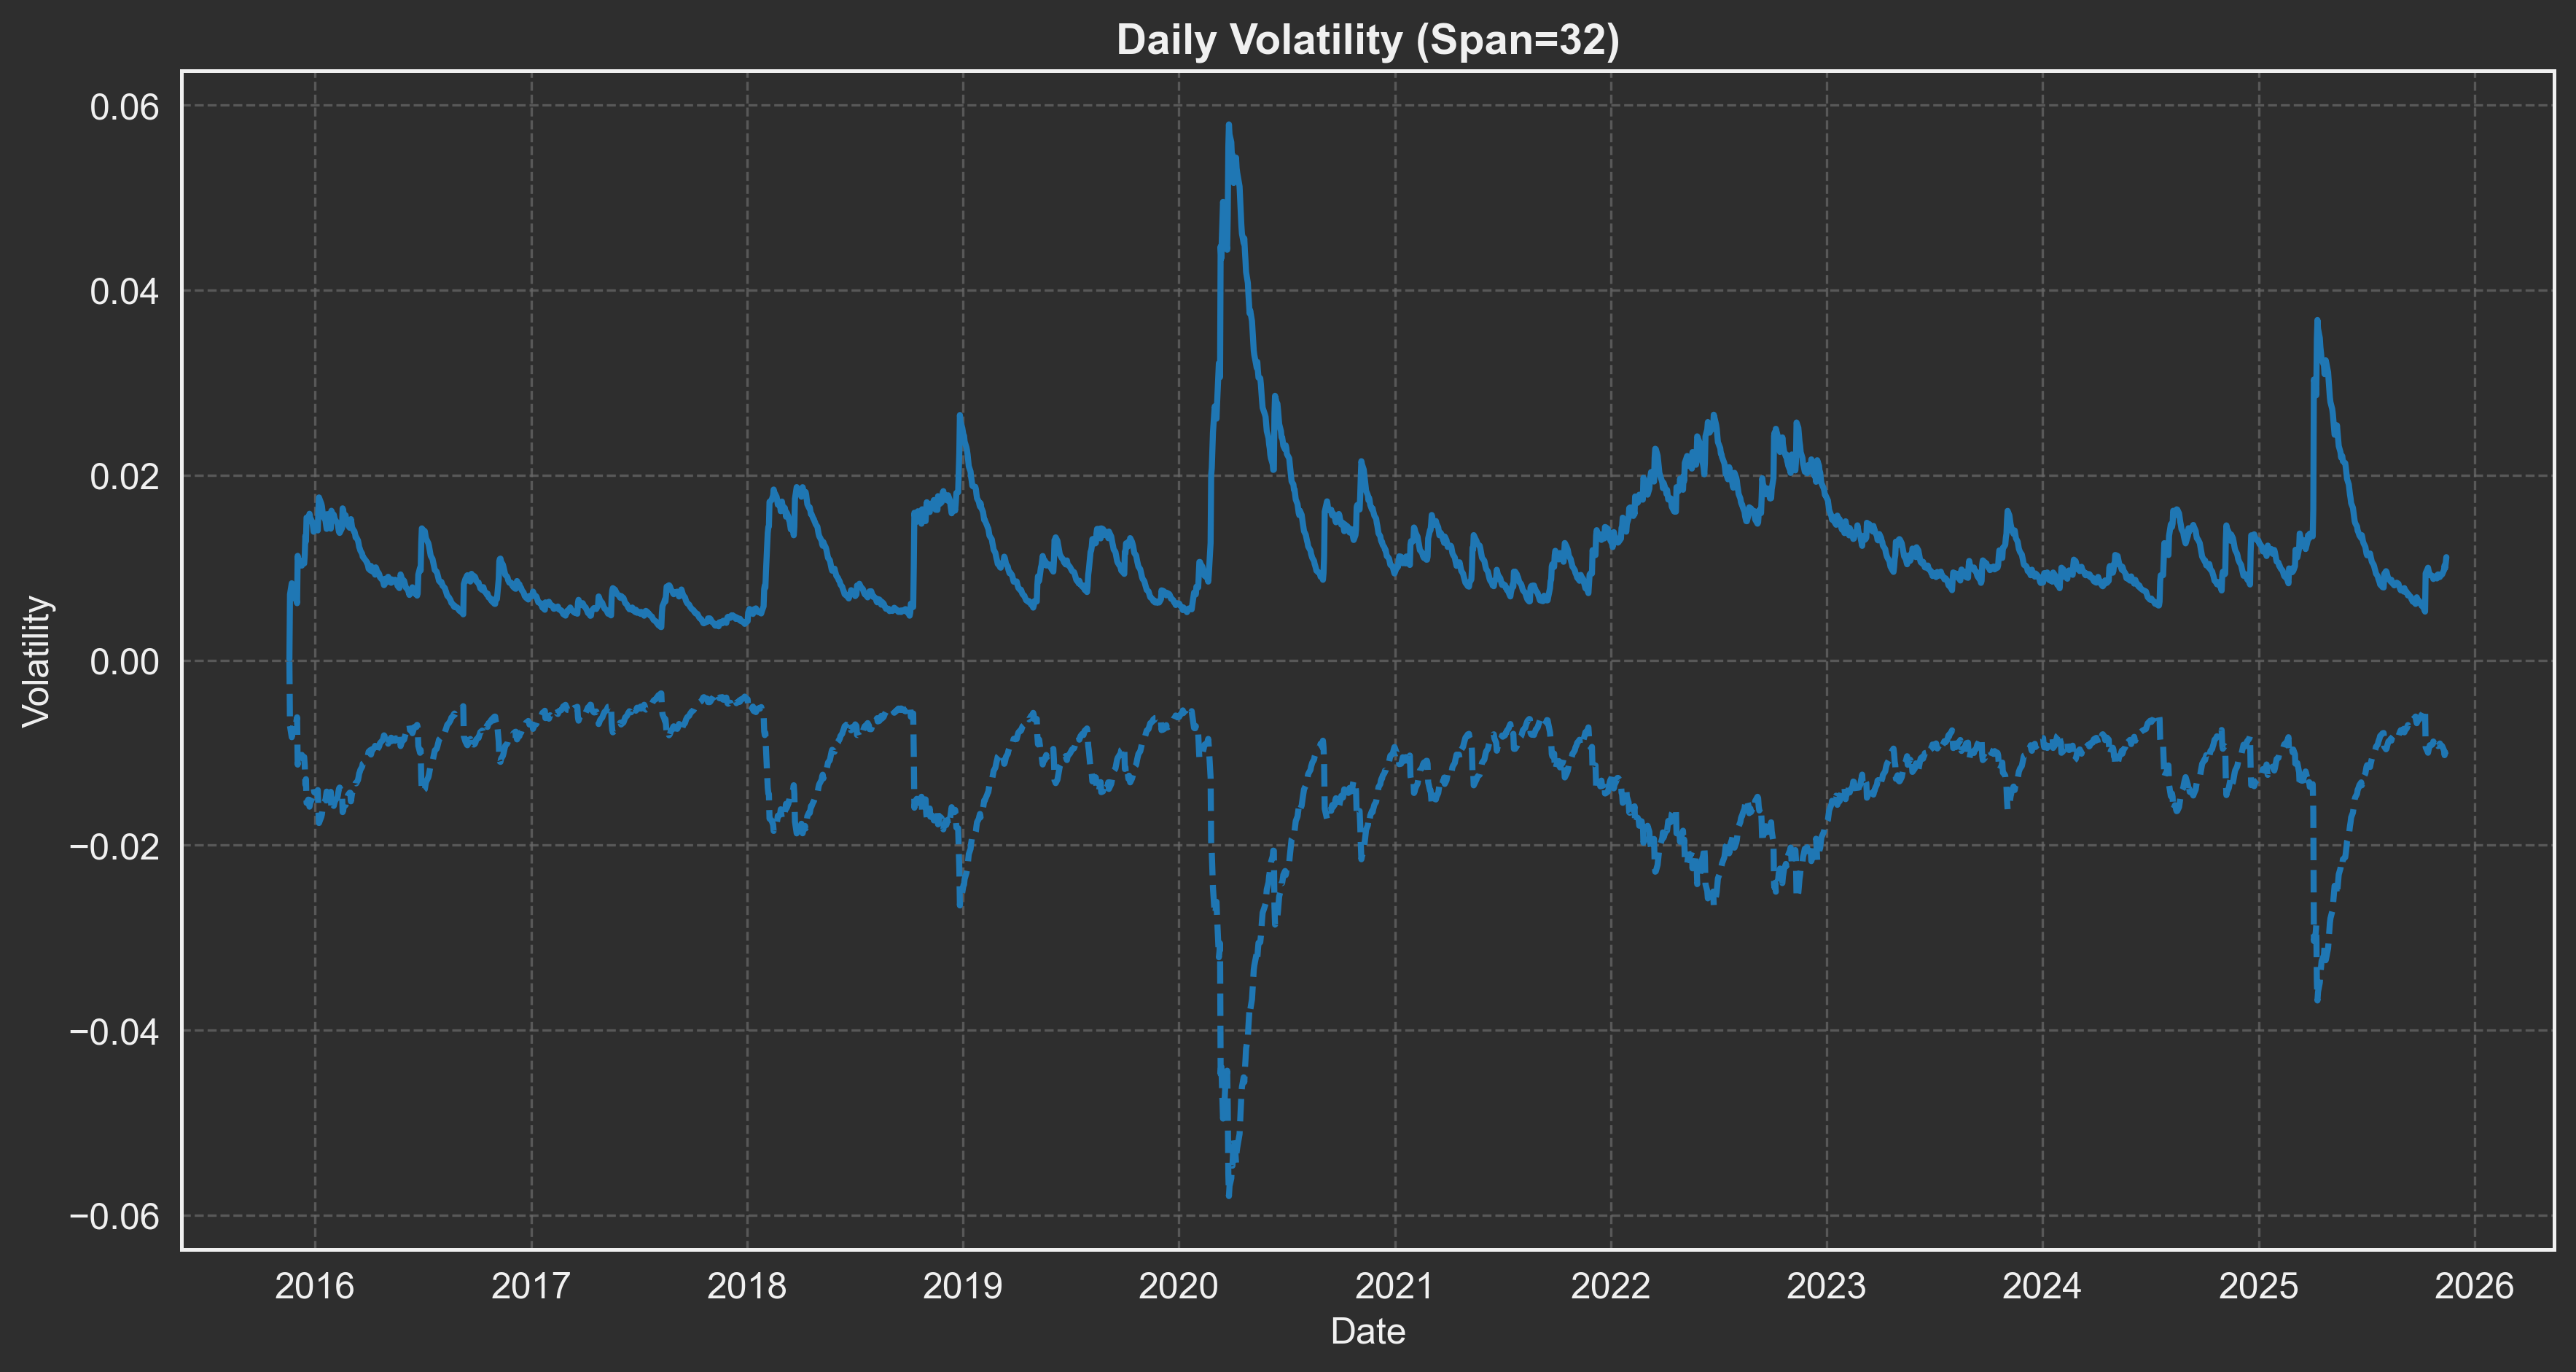

In [3]:
vols = daily_volatility_with_log_returns(close['close'], span=32)

# Plot the volatility data
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(vols.index, vols.values, label='Volatility (std)', color='C0', linewidth=2)
ax.plot(vols.index, -vols.values, label='-Volatility (std)', color='C0', linestyle='--', linewidth=2)

pub_plots.apply_plot_style(
    ax, 
    'Daily Volatility (Span=32)', 
    'Date', 
    'Volatility',
    legend_title='Series'
)
pub_plots.finalize_plot(fig, 'daily_volatility.png')

### 2.2 Generate Events and Labels

In [4]:
# Detect events using CUSUM filter
# We use a threshold of 5x the 32-day volatility
timeevents = symmetric_cusum_filter(close['close'], 5 * vols.mean())
print(f"Detected {len(timeevents)} events.")

# Define the vertical barrier (max holding period)
t1 = vertical_barrier(close['close'], timeevents, 21)

# Get meta-events (event start/end times)
ptsl = [1, 1]
events = meta_events(
    close=close['close'], 
    time_events=timeevents, 
    ptsl=ptsl, 
    target=vols, 
    return_min=0.04, 
    num_threads=1, 
    vertical_barrier_times=t1,
    side=None # No side, so labels will be {-1, 1}
)

print("Event start/end times (first touch):")
print(events.head())

Detected 2505 events.
Event start/end times (first touch):
             End Time  Base Width
2020-03-12 2020-03-13    0.044734
2020-03-13 2020-03-16    0.043414
2020-03-16 2020-03-17    0.049544
2020-03-17 2020-03-18    0.049145
2020-03-18 2020-03-23    0.048337


In [5]:
# Get the final labels (bin)
labels = meta_labeling(events, close['close'])
print("\nFinal Labels:")
print(labels.head())


Final Labels:
             End Time    Return  Label
2020-03-12 2020-03-13  0.088808    1.0
2020-03-13 2020-03-16 -0.127652   -1.0
2020-03-16 2020-03-17  0.058226    1.0
2020-03-17 2020-03-18 -0.053222   -1.0
2020-03-18 2020-03-23 -0.069362   -1.0


## 3. Sample Weighting

Now that we have our events, we can calculate weights. Overlapped labels can bias a model, so we give more weight to unique samples.

### 3.1 Concurrency

First, we calculate the number of concurrent, active events for each bar in our series.

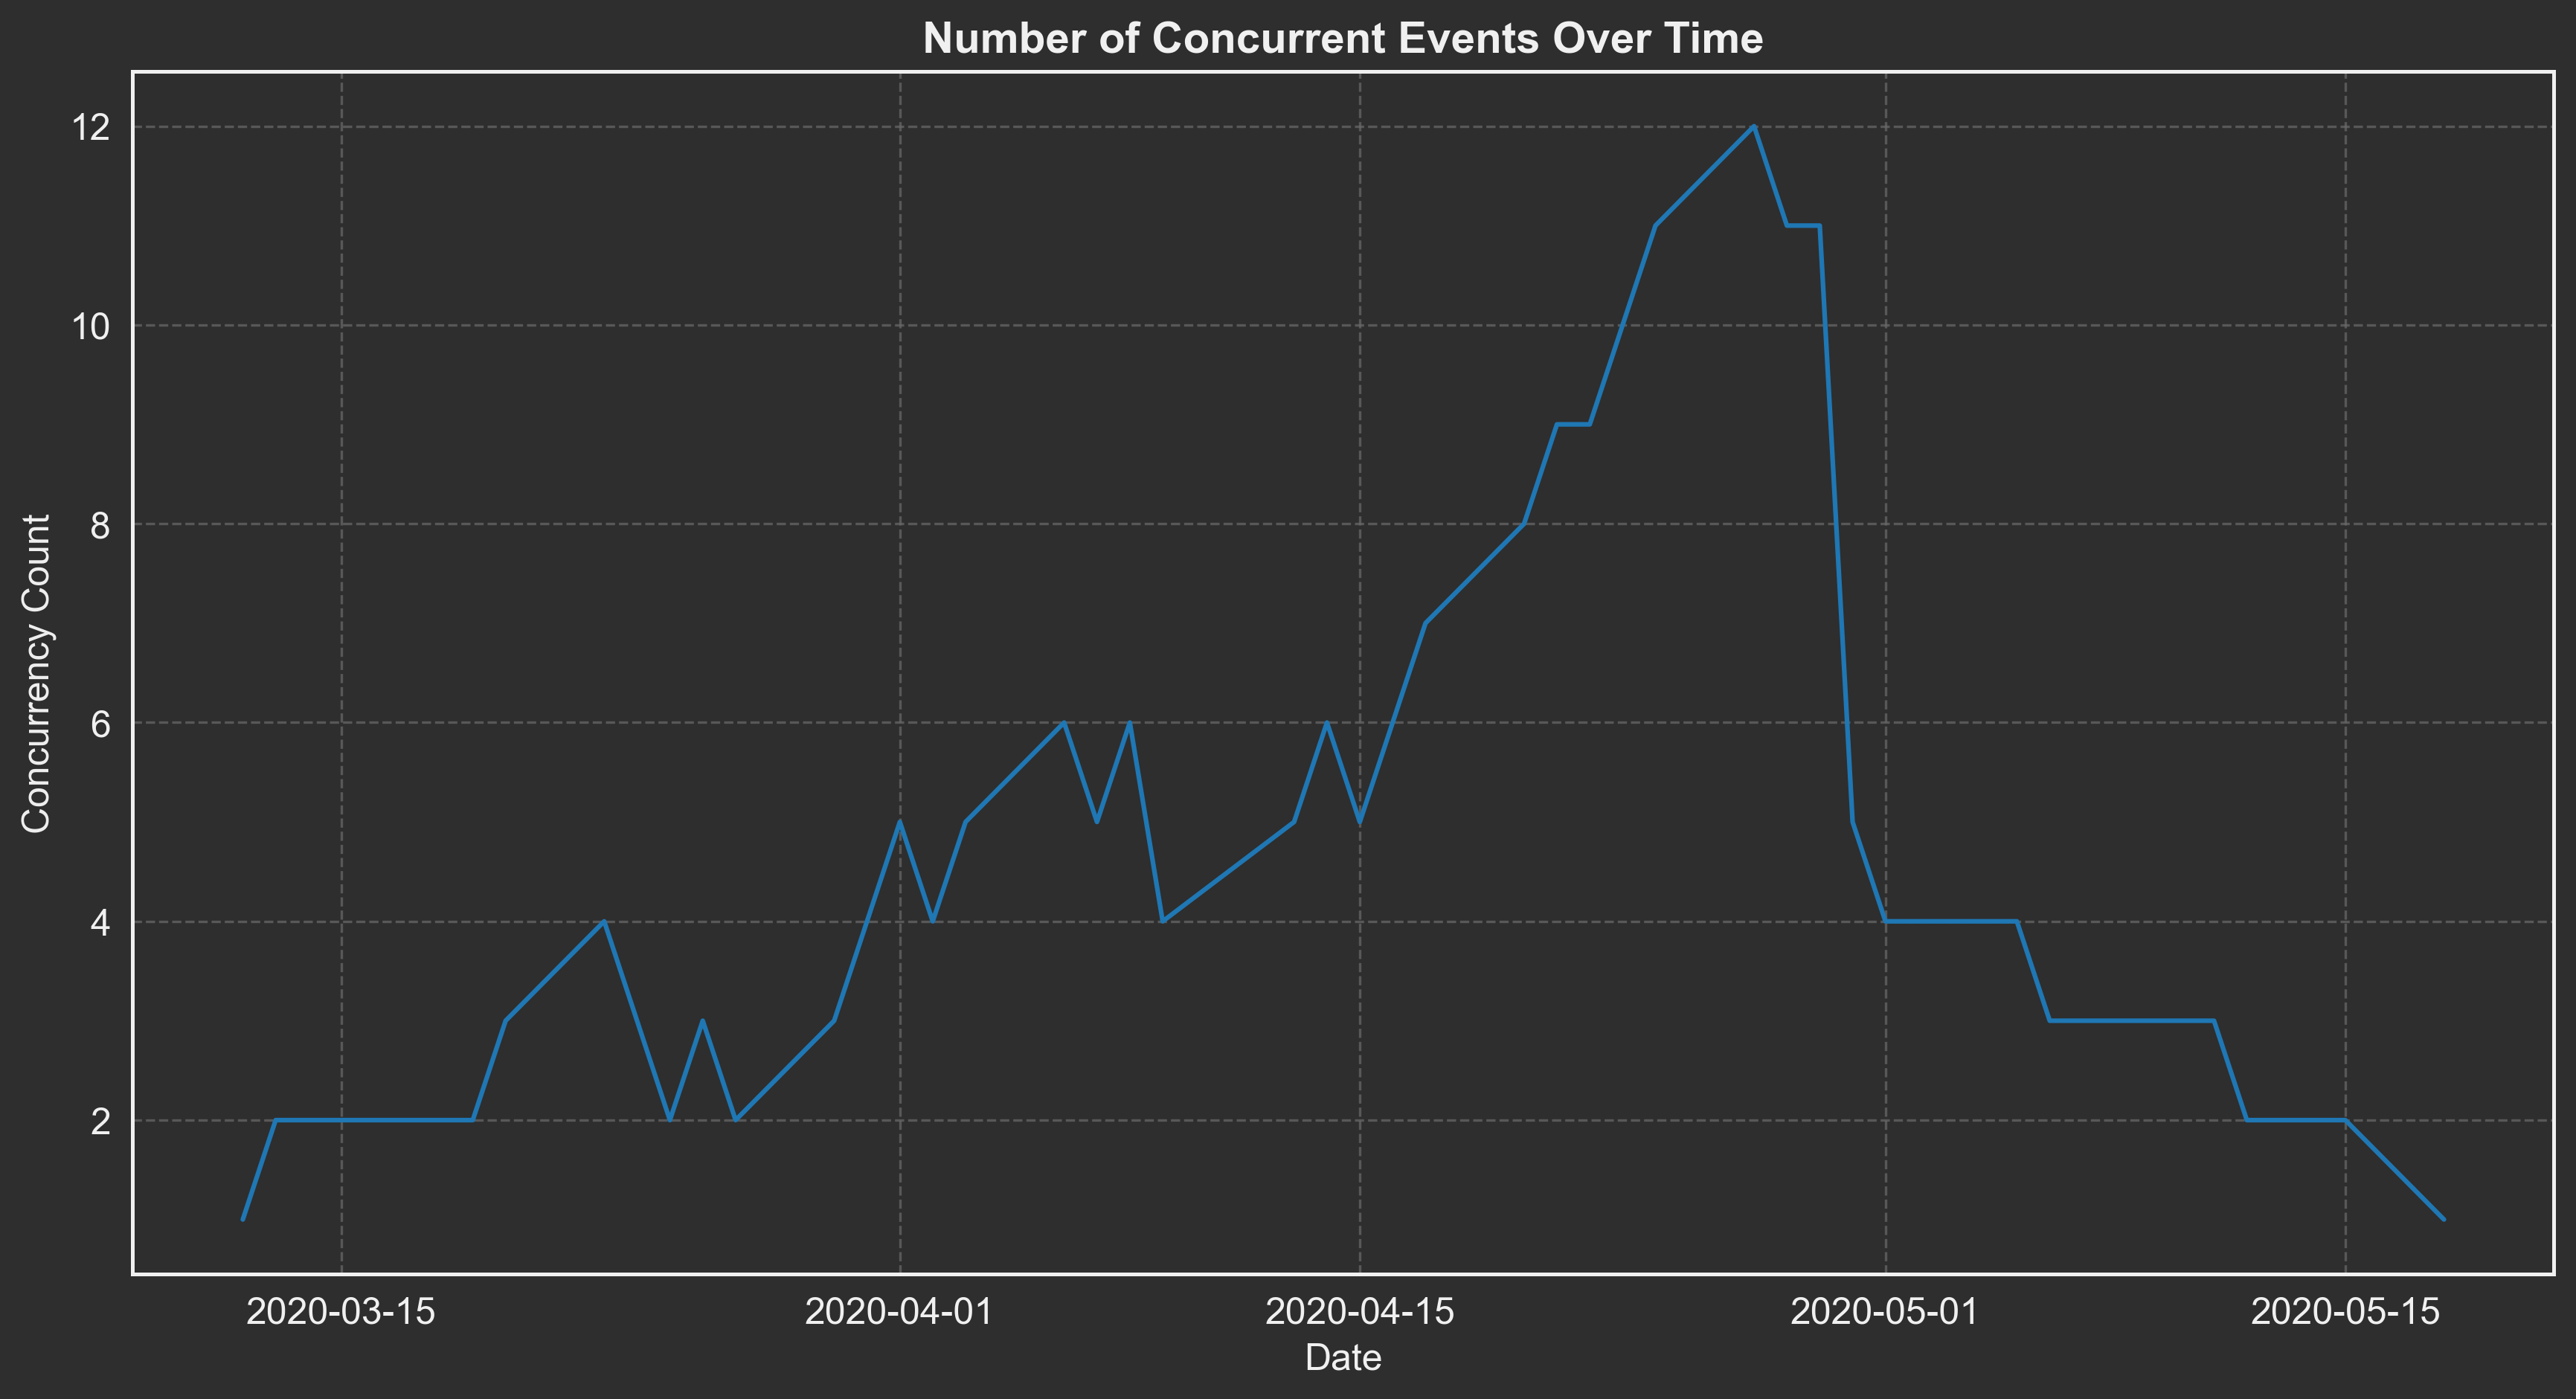

In [6]:
# events['End Time'] is a Series: index=event start, value=event end
concurrency = expand_label_for_meta_labeling(
    close_index=close.index, 
    timestamp=events['End Time'], 
    molecule=events.index
)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(concurrency.index, concurrency.values, label='Concurrency')
pub_plots.apply_plot_style(
    ax, 
    'Number of Concurrent Events Over Time', 
    'Date', 
    'Concurrency Count'
)
pub_plots.finalize_plot(fig, 'concurrency_plot.png')

### 3.2 Return-Attribution Sample Weights

This is the recommended method. The weight is based on the event's absolute return, divided by its concurrency. This gives more weight to important (high-return) and unique (low-concurrency) events.

In [7]:
# Sample return weight by absolute return
abs_weight = sample_weight_absolute_return_meta_labeling(
    timestamp=events['End Time'], 
    price=close['close'], 
    molecule=events.index
)

print(abs_weight.head())

2020-03-12    3.420863
2020-03-13    2.564900
2020-03-16    2.202525
2020-03-17    1.320586
2020-03-18    1.212616
dtype: float64


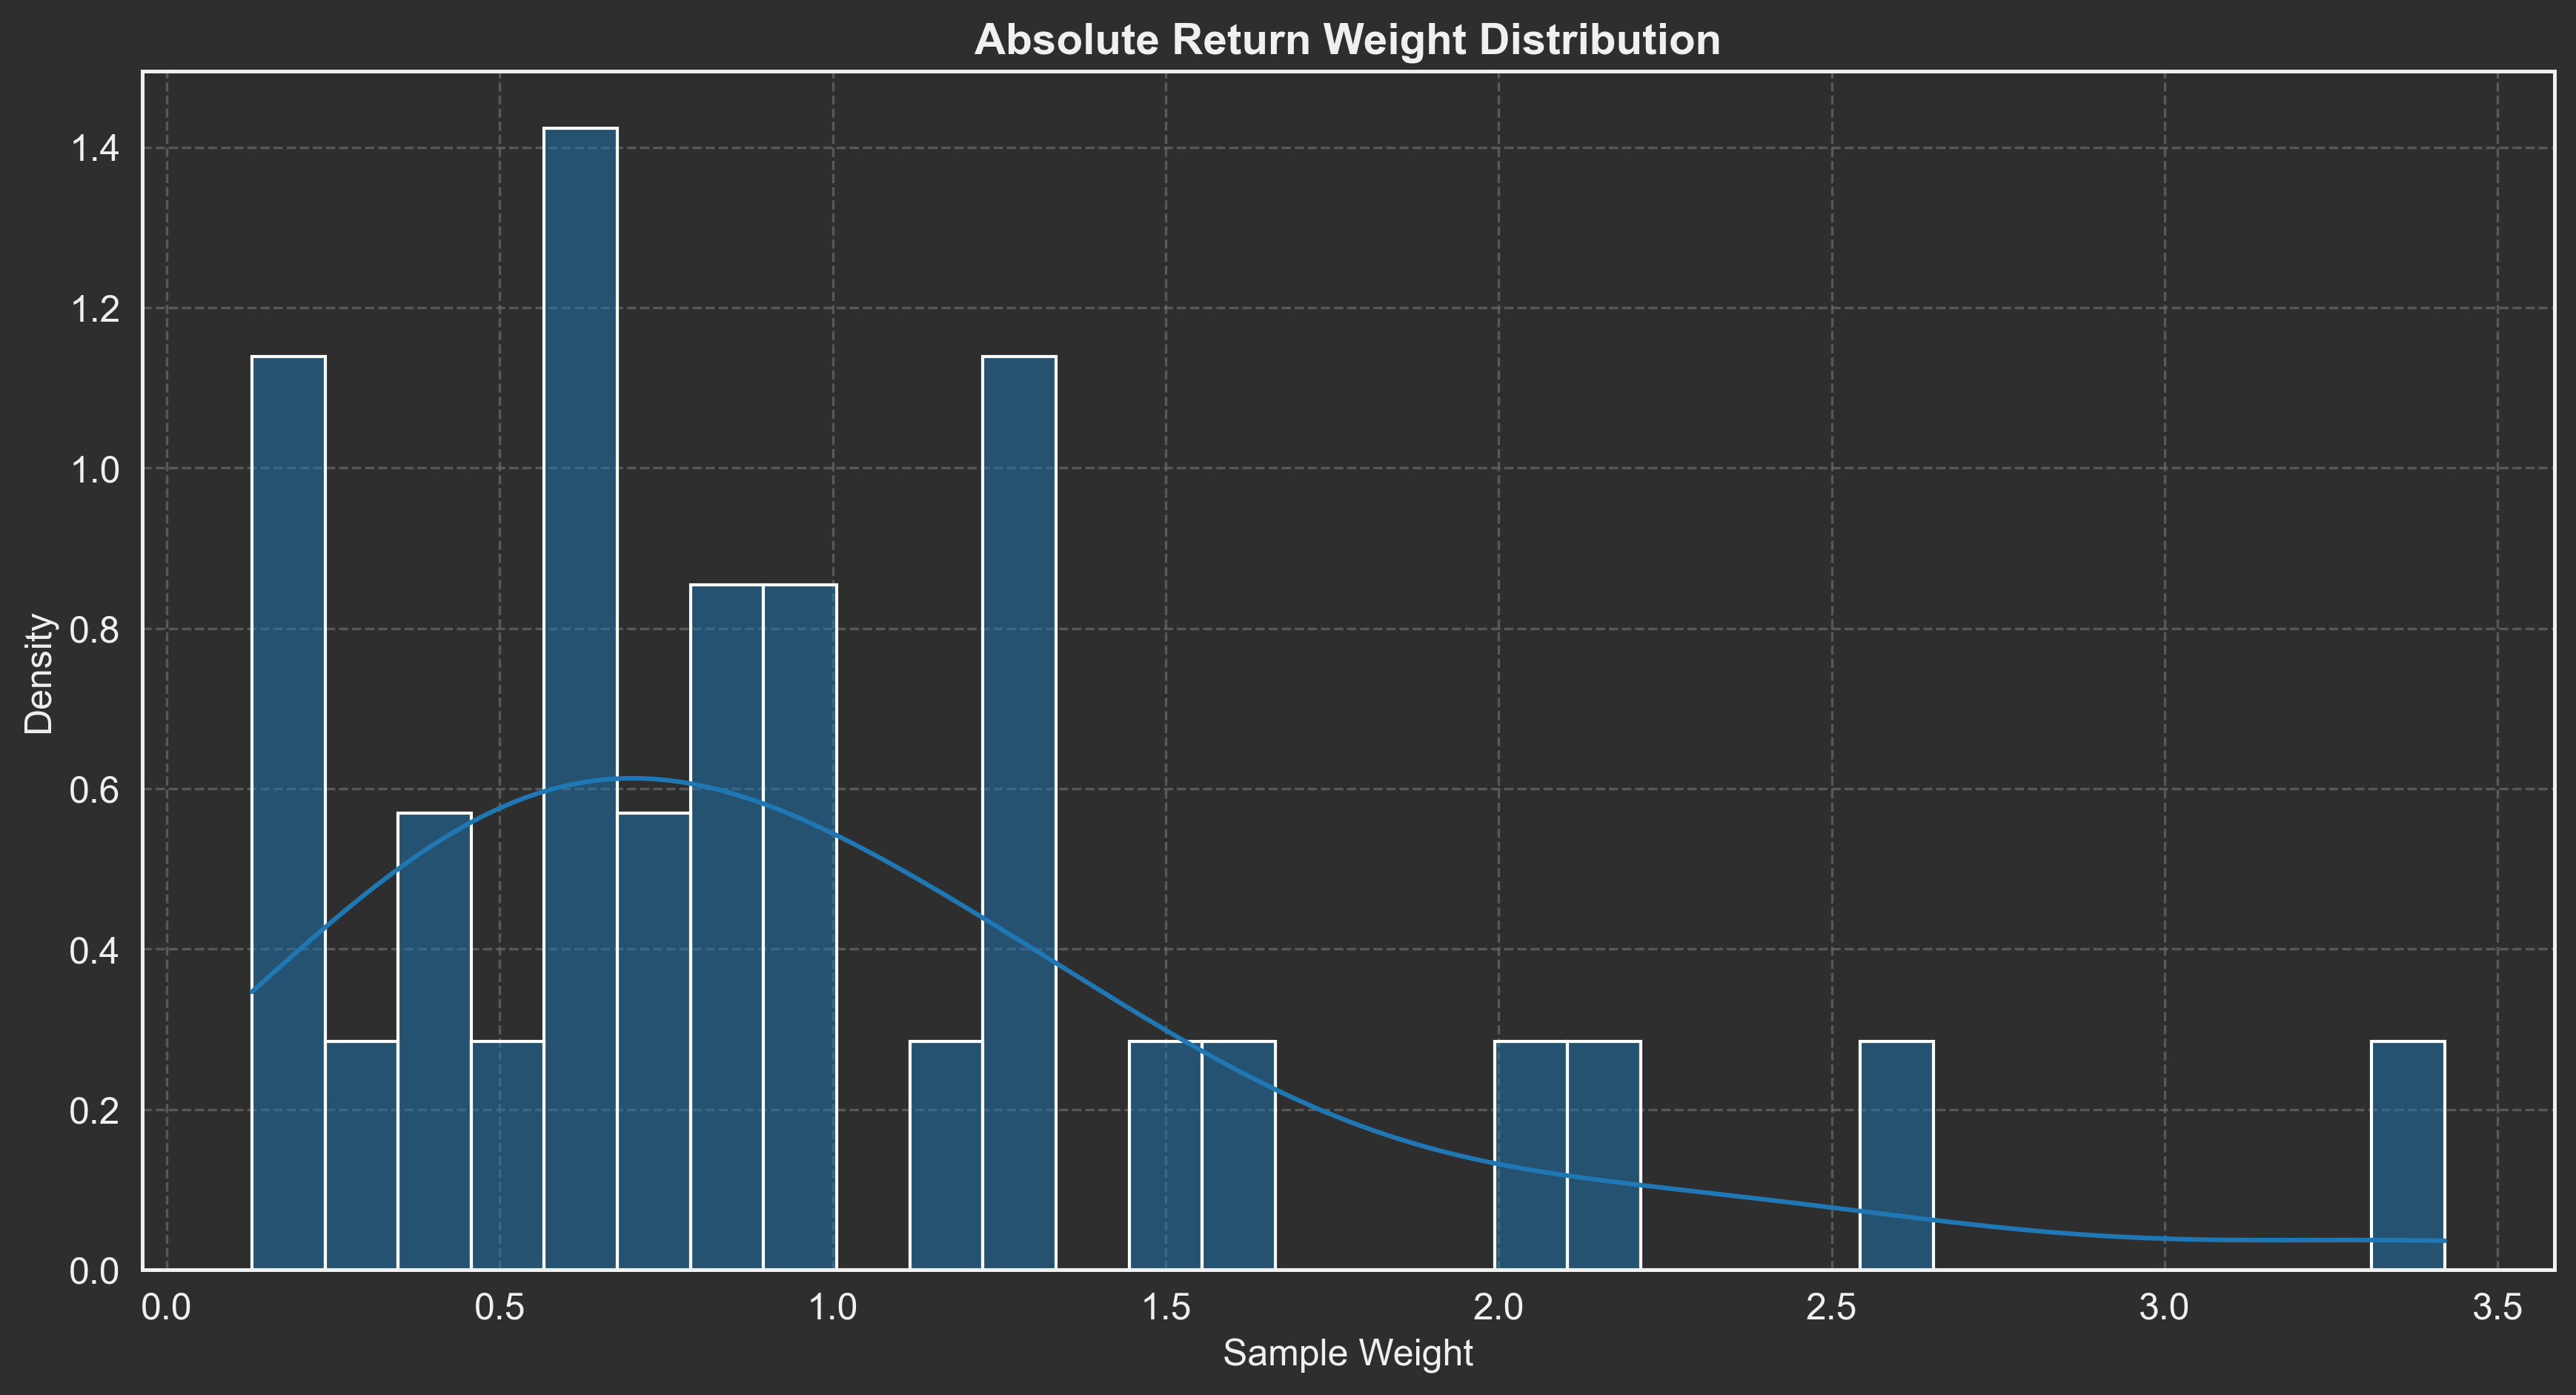

In [8]:
# Plot the distribution of absolute weights
fig, ax = plt.subplots(figsize=(14, 7))
sns.histplot(abs_weight.dropna(), ax=ax, kde=True, bins=30, label='Absolute Return Weight', stat='density')
pub_plots.apply_plot_style(
    ax, 
    'Absolute Return Weight Distribution', 
    'Sample Weight', 
    'Density'
)
pub_plots.finalize_plot(fig, 'abs_return_weight_hist.png')

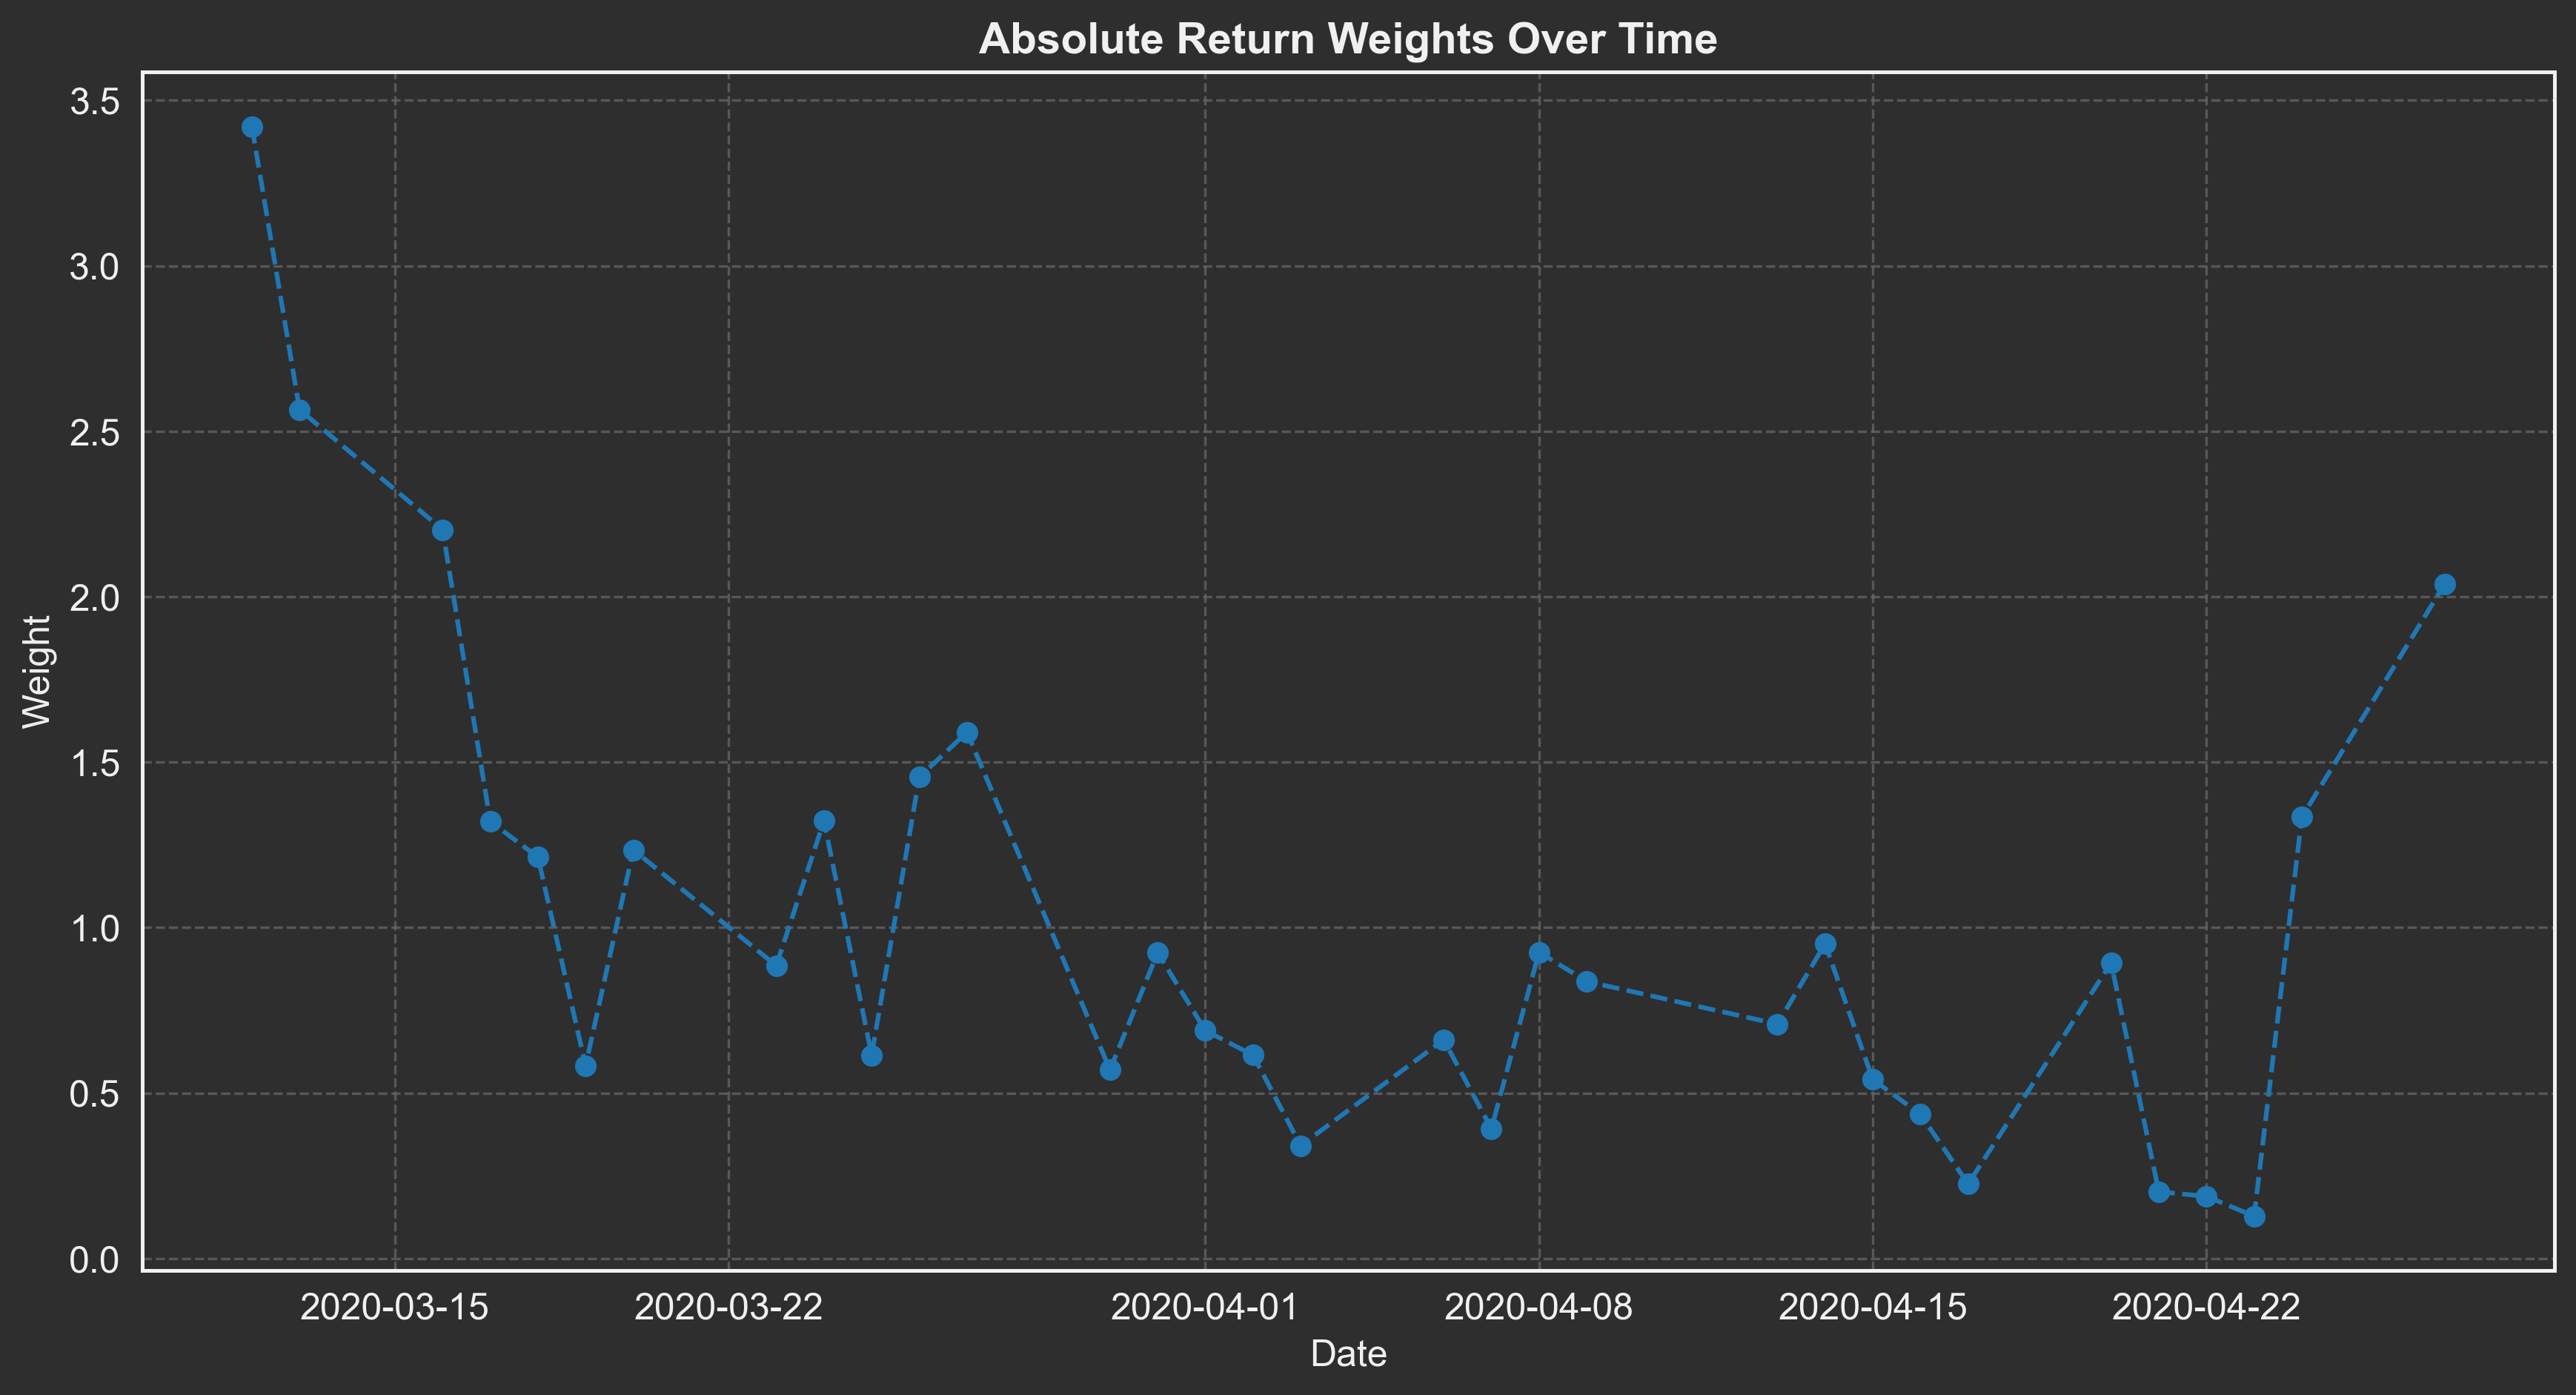

In [9]:
# Plot weights over time
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(abs_weight.index, abs_weight.values, marker='o', linestyle='--', label='Abs. Return Weight')
pub_plots.apply_plot_style(
    ax, 
    'Absolute Return Weights Over Time', 
    'Date', 
    'Weight'
)
pub_plots.finalize_plot(fig, 'abs_return_weight_series.png')

### 3.3 Time-Decay Weights

We can optionally apply a time-decay factor to our weights, giving more importance to recent observations.

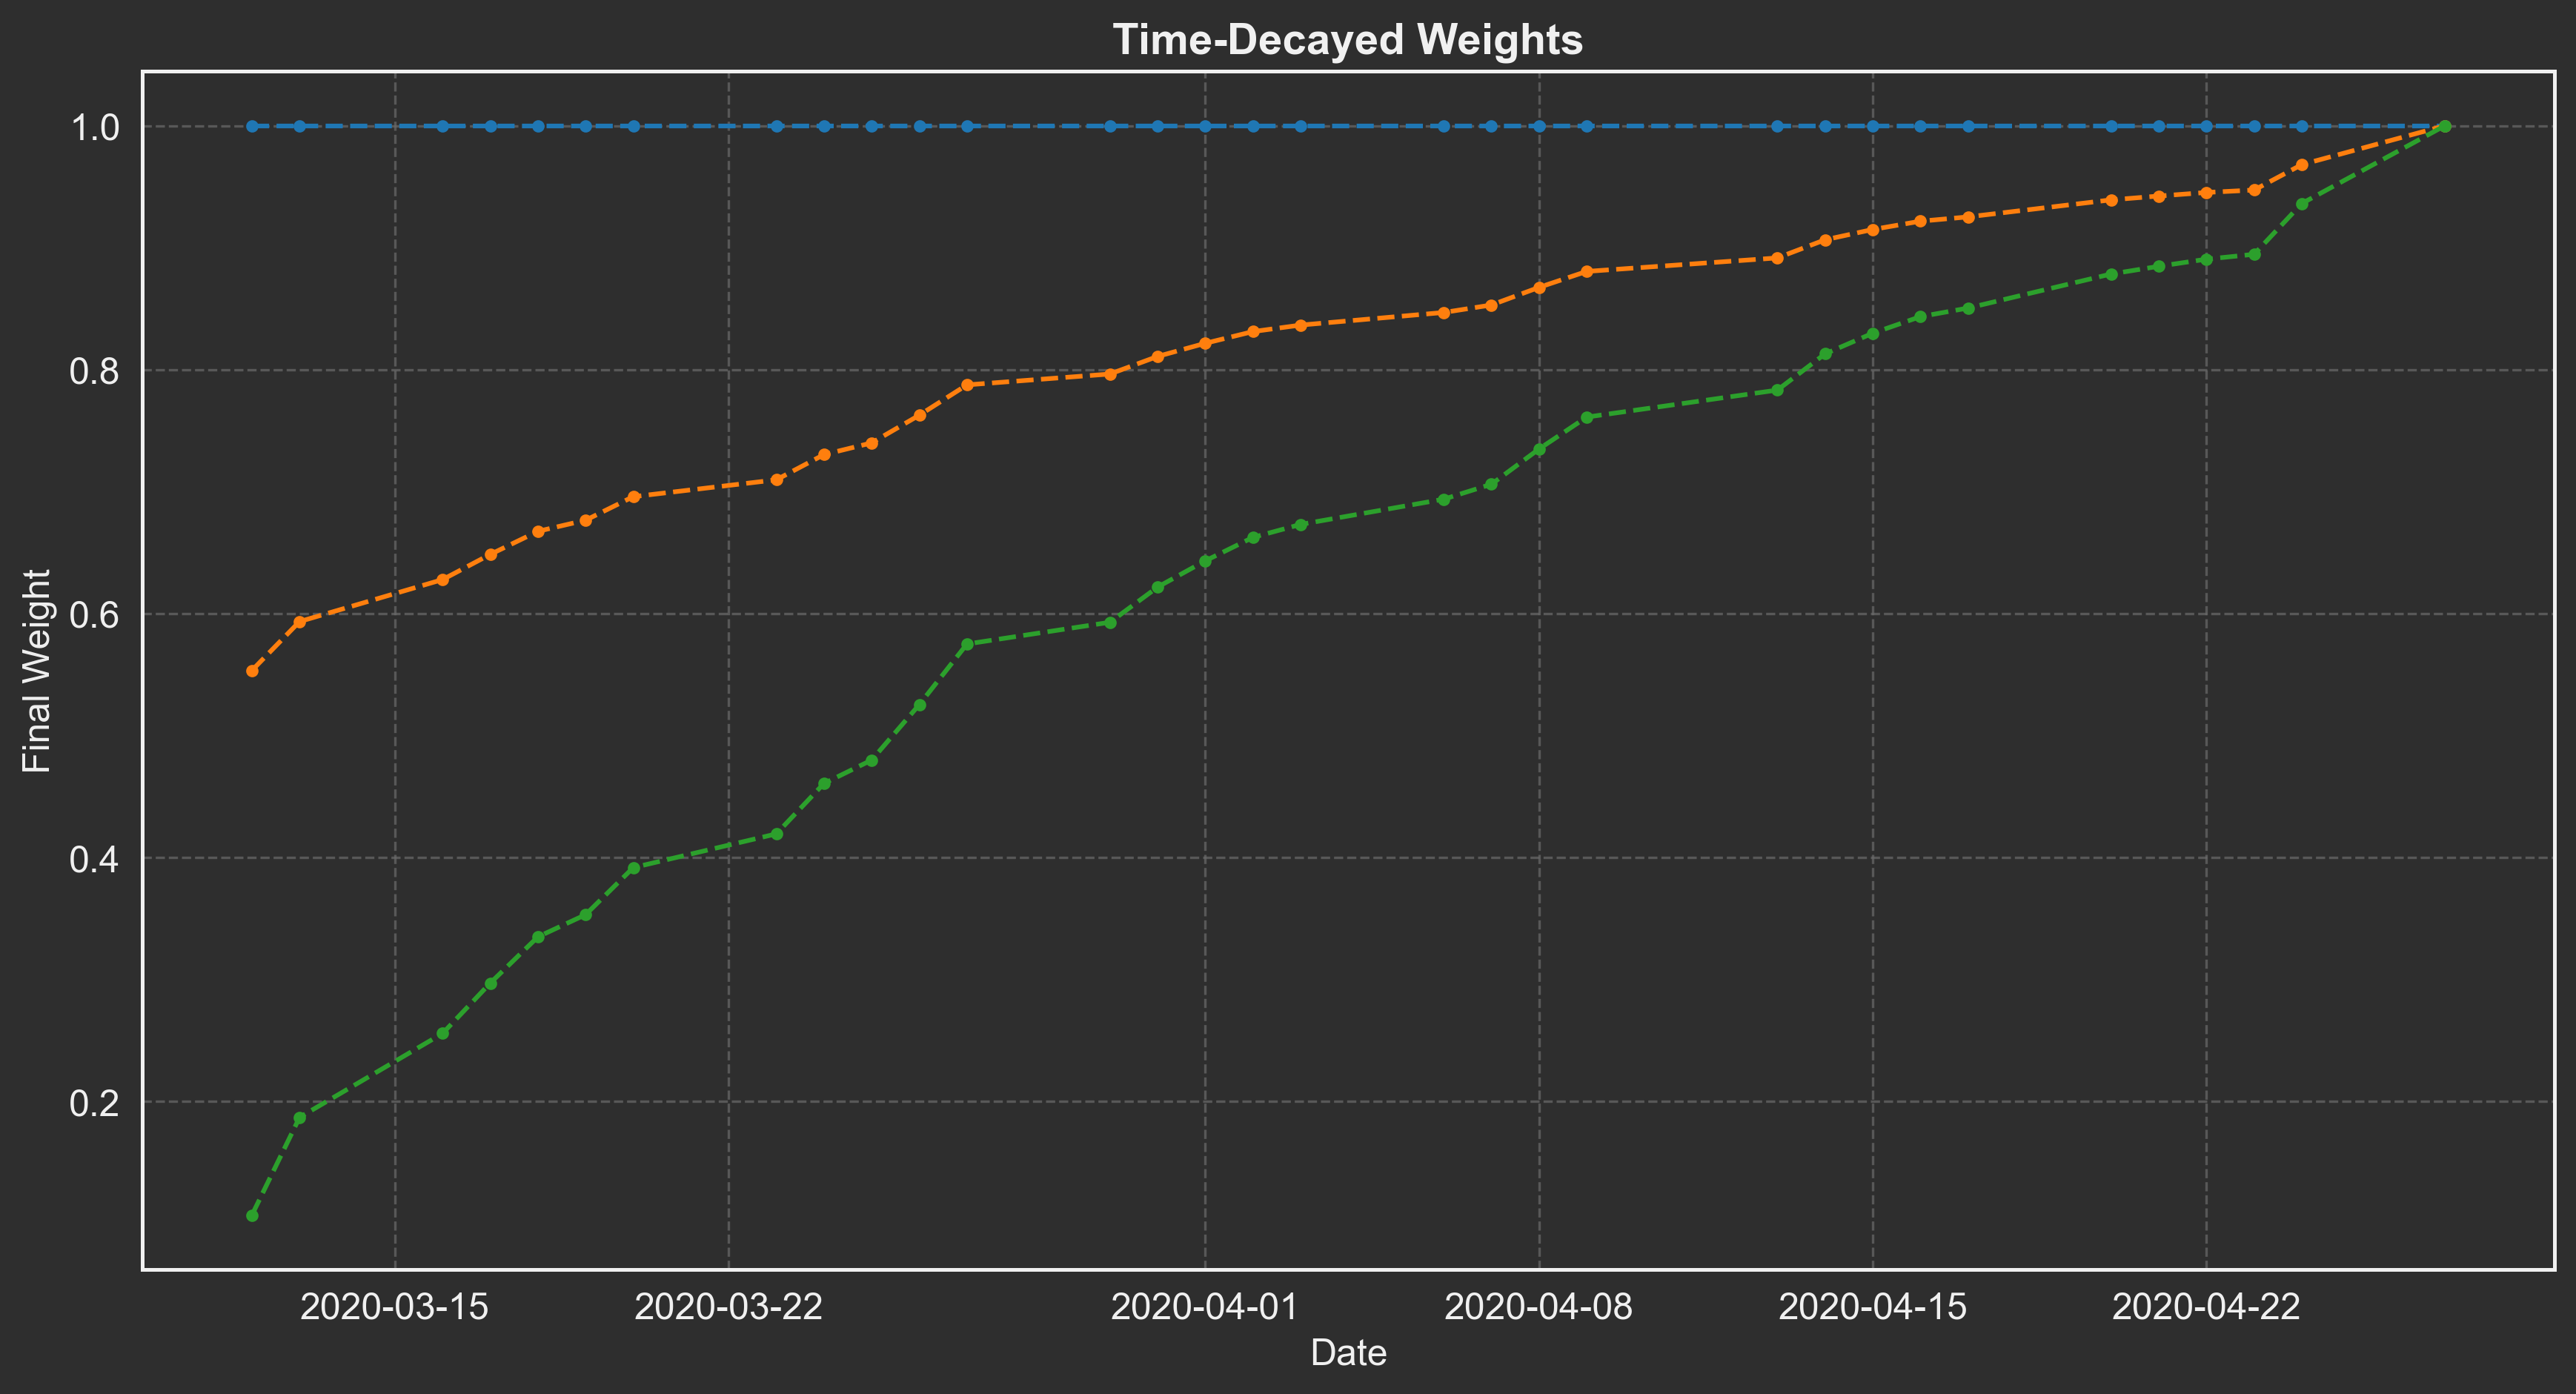

In [10]:
# Different clf_last_weight values
clf_last_weights = [1.0, 0.5, 0.0]

fig, ax = plt.subplots(figsize=(14, 7))

for weight in clf_last_weights:
    clf_weight = calculate_time_decay(abs_weight, clf_last_weight=weight)
    ax.plot(clf_weight.index, clf_weight.values, marker='.', linestyle='--', 
            label=f'Decay (oldest weight={weight})')

pub_plots.apply_plot_style(
    ax, 
    'Time-Decayed Weights', 
    'Date', 
    'Final Weight',
    legend_title='Decay Type'
)
pub_plots.finalize_plot(fig, 'time_decay_plot.png')

## 4. Average Uniqueness & Sequential Bootstrap

This section demonstrates the concepts of **Average Uniqueness** and **Sequential Bootstrapping**. We first define helper functions for an indicator matrix and a Monte Carlo simulation.

### 4.1 Average Uniqueness on Real Data

In [11]:
def create_index_matrix(bar_ix: pd.Index, t1: pd.Series) -> pd.DataFrame:
    """
    Creates an indicator matrix (T x N) indicating which bars (T) 
    are part of each event (N).
    """
    ind_matrix = pd.DataFrame(0, index=bar_ix, columns=range(t1.shape[0]))
    for i, (t0, t1_value) in enumerate(t1.items()):
        if pd.notna(t1_value):
            ind_matrix.loc[t0:t1_value, i] = 1
    return ind_matrix

# Create the indicator matrix from our events
indM = create_index_matrix(close.index, events['End Time'])
print("Indicator Matrix Shape:", indM.shape)


Indicator Matrix Shape: (2515, 32)


In [12]:
# Calculate the average uniqueness
avgU = calculate_average_uniqueness(indM)
print("Average Uniqueness (first 5 events):")
print(avgU.head())

Average Uniqueness (first 5 events):
0    0.750000
1    0.500000
2    0.500000
3    0.500000
4    0.395833
dtype: float64


### 4.2 Monte Carlo Simulation: Sequential vs. Standard Bootstrap

We now run a simulation to show why sequential bootstrapping is superior. It generates samples with much higher average uniqueness than the standard random-draw method.

Note: We reduce iterations to 100 for speed. Increase to 1000+ for a smoother distribution.

In [13]:
def perform_sequential_bootstrap(
    indM: pd.DataFrame, 
    s_len: int = None
) -> list:
    """ Sequential bootstrap sampling (Notebook-local definition) """
    if s_len is None:
        s_len = indM.shape[1]
        
    phi = []
    while len(phi) < s_len:
        avg_u = pd.Series(dtype='float64')
        for i in indM.columns:
            if i in phi:
                continue
            phi_ = phi + [i]
            avg_u.loc[i] = calculate_average_uniqueness(indM[phi_]).iloc[-1]
        
        if avg_u.empty:
            break # No more samples to add
            
        prob = (avg_u / avg_u.sum()).fillna(0)
        phi += [np.random.choice(avg_u.index, p=prob)]
        
    return phi

In [14]:
def random_time_stamp(n_observation, n_bars, maximum_holding):
    """ Generates random event timestamps for simulation. """
    data = {'date': np.zeros(n_observation), 'timestamp': np.zeros(n_observation)}
    timestampp = pd.DataFrame(data)
    for i in range(n_observation):
        date = random.randint(0, n_bars)
        t = date + random.randint(1, maximum_holding + 1)
        timestampp.loc[i, 'date'] = date
        timestampp.loc[i, 'timestamp'] = t
    timestampp = timestampp.sort_values(by=['date'])
    # Convert to integer indices for bar_index
    timestampp['date'] = timestampp['date'].astype(int)
    timestampp['timestamp'] = timestampp['timestamp'].astype(int)
    timestampp = timestampp.set_index('date')['timestamp']
    return timestampp

def monte_carlo_simulation_for_sequential_bootstraps(n_observation, n_bars, maximum_holding):
    """ Runs one simulation trial. """
    timestampp = random_time_stamp(n_observation, n_bars, maximum_holding)
    
    bar_index = pd.Index(range(int(timestampp.max()) + 1))
    
    # Fix typo: create_index_matrix
    index_matrix_ = create_index_matrix(bar_index, timestampp)
    
    # Standard bootstrap
    rho = random.sample(range(index_matrix_.shape[1]), index_matrix_.shape[1])
    standard_uniqueness = np.mean(calculate_average_uniqueness(index_matrix_.iloc[:, rho]))
    
    # Sequential bootstrap
    rho = perform_sequential_bootstrap(index_matrix_, index_matrix_.shape[1])
    sequential_uniqueness = np.mean(calculate_average_uniqueness(index_matrix_.iloc[:, rho]))
    
    return standard_uniqueness, sequential_uniqueness

def simulate_sequential_vs_standard_bootstrap(iteration, n_observation, n_bars, maximum_holding):
    """ Runs the full simulation. """
    seq_u = np.zeros(iteration)
    std_u = np.zeros(iteration)
    for i in range(iteration):
        if i % 10 == 0:
            print(f"Iteration {i}...")
        standard_uniqueness, sequential_uniqueness = monte_carlo_simulation_for_sequential_bootstraps(n_observation, n_bars, maximum_holding)
        seq_u[i] = sequential_uniqueness
        std_u[i] = standard_uniqueness
    print("Simulation complete.")
    return seq_u, std_u

In [15]:
# Run simulation (100 iterations for speed, increase for accuracy)
seqU, stdU = simulate_sequential_vs_standard_bootstrap(100, 10, 100, 5)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'seqU': seqU, 'stdU': stdU})

Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Iteration 50...
Iteration 60...
Iteration 70...
Iteration 80...
Iteration 90...
Simulation complete.


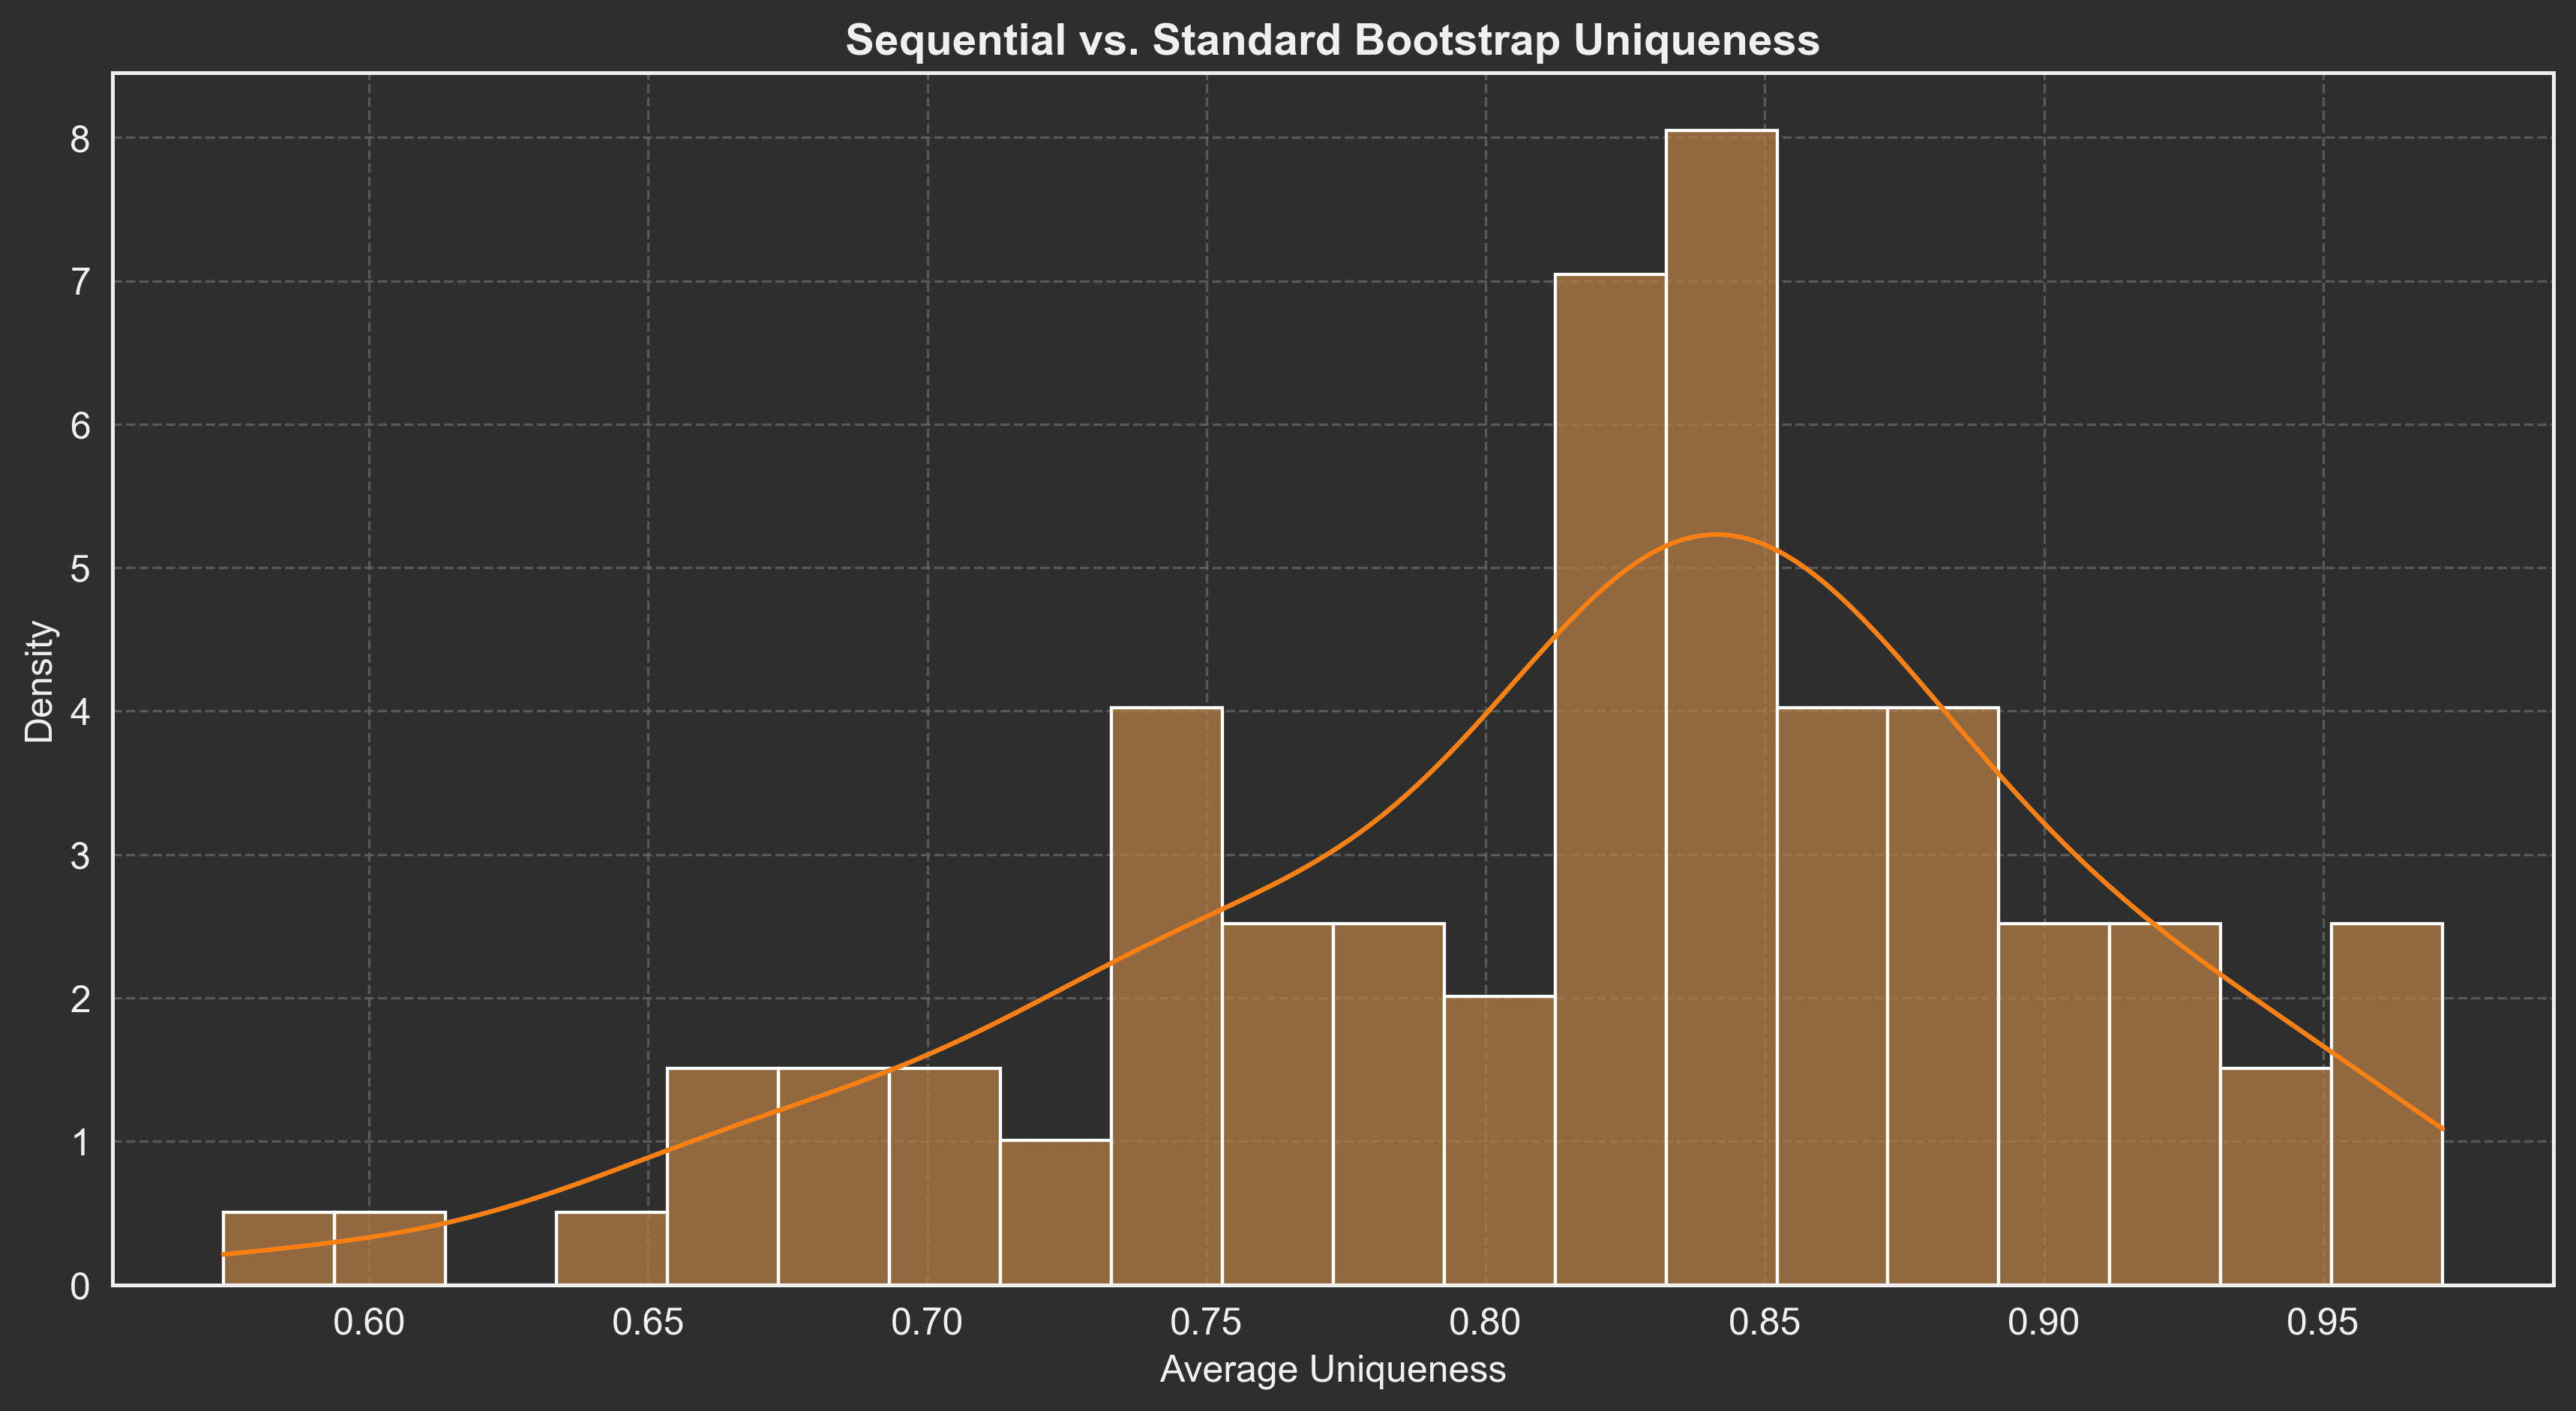

In [16]:
# Plot the distributions
fig, ax = plt.subplots(figsize=(14, 7))
sns.histplot(plot_data['seqU'], ax=ax, kde=True, label='Sequential Bootstrap', color='C0', stat='density', bins=20)
sns.histplot(plot_data['stdU'], ax=ax, kde=True, label='Standard Bootstrap', color='C1', stat='density', bins=20)

pub_plots.apply_plot_style(
    ax, 
    'Sequential vs. Standard Bootstrap Uniqueness', 
    'Average Uniqueness', 
    'Density', 
    legend_title='Bootstrap Method'
)
pub_plots.finalize_plot(fig, 'bootstrap_comparison.png')